#                   Classification - MNIST

In [1]:
# Helper for downloading popular dataset
from sklearn.datasets import fetch_openml

# Download the dataset
mnist = fetch_openml('mnist_784', version=1, as_frame=False) # as_frame returns pd.DataFrame if set to true otherwise gives an nd.array
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X , y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


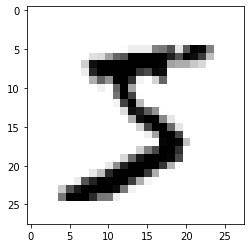

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.show()

In [4]:
y[0] # 

'5'

In [5]:
import numpy as np

y = y.astype(np.uint8) # convert from string to nd.uint8

In [6]:
# Split into train, test => MNIST already has this segregated
# This dataset has already been shuffled. Order of inputs affects some models
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Binary Classifier - Number '5' detector

In [7]:
# Separate labels of 5's and not-5's
y_train_5 = y_train == 5
y_test_5 = y_test == 5

In [8]:
# Stochastic Gradient Classifier - capable of handling large datasets efficiently
# Deals with training instances independently taking one at a time(also suited for Online-Learning)
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier()
sgd_clf.fit(X_train, y_train_5)

SGDClassifier()

In [9]:
sgd_clf.predict([some_digit])

array([False])

### Cross-Validate the model

In [10]:
# Custom stratified cross-validation
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

# Produces 3 separate train, tests from the training set alone
for train_index, test_index in skfolds.split(X_train, y_train_5):
    # Clones the classifier
    clone_clf = clone(sgd_clf)

    # Split the train set
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]

    # Split the test set
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    # Fit the classifier
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)

    # Sum the number of correct predictions
    n_correct = sum(y_pred == y_test_fold)

    # Ratio of predictions vs correct results
    print(n_correct / len(y_pred))

0.96865
0.9642
0.96145


In [11]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, scoring="accuracy", cv=3)

array([0.9701 , 0.964  , 0.96435])

In [12]:
# Too good to be true?
# Implement a basic estimator and try again
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X),1), dtype=bool)

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, scoring="accuracy", cv=3)

array([0.91125, 0.90855, 0.90915])

Create a Confusion Matrix:
---------------------
Confusion Matrix is a matrix that contains info on the number of times the classifier predict a `x` as a different label

In [13]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [14]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[54144,   435],
       [ 1701,  3720]], dtype=int64)

In [15]:
# Confusion Matrix if the model was on point
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

Insights from Confusion matrix:
----------------

### i) Accuracy of the model:

precision = TP / (TP + FP) 

Precision score is `basically_the_number_of_5's_the_model_predicted_correctly_among_all_the_5's_it_predicted`. A few could have been wrong.
__________________________________
### ii) Ratio of correct_predictions / correct_predictions + wrongly predicted actual ones(False negatives):

recall = TP / (TP + FN)

Recall score is `basically the number of 5's the model predicted correctly among the actual 5's in given_set`. A few correct 5's could've been wrongly predicted as non-5's.

where,

TP = True positive

FP = False positive


In [16]:
from sklearn.metrics import precision_score, recall_score 

precision = precision_score(y_train_5, y_train_pred) # 3847 / (3847 + 934)
print(f"Precision score = {precision}") 
recall = recall_score(y_train_5, y_train_pred) # 3847 / (3847 + 1547)
print(f"Recall score = {recall}")

Precision score = 0.8953068592057761
Recall score = 0.6862202545655783


F1 score:
----

F1 score is the harmonic mean of Precision and recall scores

F1 = TP / (TP + ((FN + FP) / 2))

In [17]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7769423558897243

In [18]:
# For SGDClassifier: 
# Greater the threshold greater the precision
# Lesser the threshold greater the recall
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([-1855.3345447])

In [19]:
# So if we think the threshold was 0, the prediction will always be true and be positive, extreme recall
y_scores > 0

array([False])

In [20]:
#  Raising the threshold now increases precision and reduces recall, creating many FN but increases precision
y_scores > 8000

array([False])

In [21]:
# How to select threshold value?
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [22]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

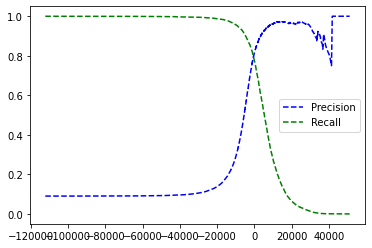

In [23]:
def plot_precision_recall_vs_threshold(precision, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
    plt.legend()

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

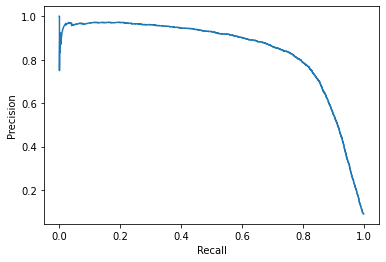

In [24]:
plt.plot(recalls, precisions)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [25]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [26]:
y_train_pred_90 = y_scores >= threshold_90_precision

In [27]:
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.9001097694840834
0.6050544180040582


In [28]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

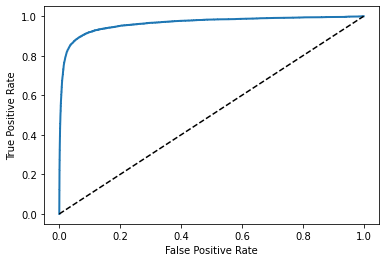

In [29]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1], 'k--') # Dashed diagonal
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

plot_roc_curve(fpr, tpr)
plt.show()

In [30]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9636287773285676

In [31]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_proba_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

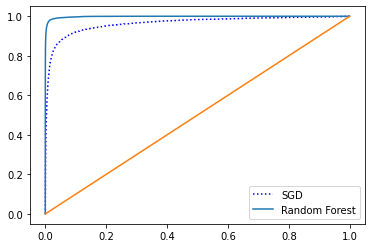

In [32]:
y_scores_forest = y_proba_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

# RFC is the better model
plt.plot(fpr, tpr,"b:", label="SGD")
plt.plot(fpr_forest, tpr_forest, label="Random Forest")
plt.plot([0,1], [0,1])
plt.legend(loc="lower right")
plt.show()

ROC AUC for Forest: 0.9983436731328145


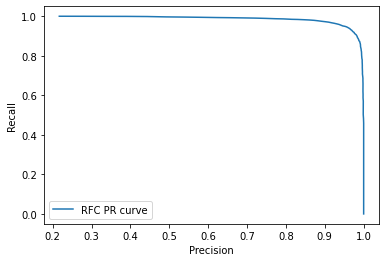

In [33]:
print("ROC AUC for Forest:", roc_auc_score(y_train_5, y_scores_forest)) # Better if closer to 1, bad if closer to 0.5
forest_precision, forest_recalls, forest_thresholds = precision_recall_curve(y_train_5, y_scores_forest)

plt.plot(forest_precision, forest_recalls, label="RFC PR curve")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.legend()
plt.show()

Multi-Class Classification
---------

Some classifiers support multi-class classification natively. Eg: SGD, RandomForestClassifier, naive Bayes classifier.
Other classifiers that stricly do binary classification(such as SVM and Logistic regression) need to be trained against every class. 
Basically a One-vs-Rest(`1` detector, `2` detector ....) or One-vs-One i.e we train them on pairs of classes(eg: in MNIST we can do `1` vs `2`, `1` vs `3`, `1` vs `4` .... and so on for other classifiers).

No. of classifiers to be trained for OvO is `N x (N -1) / 2`. For MNIST it is 45 classifiers! For classification, we'd need to run the image in all 45 classifiers again!
Some classifiers are bad with large datasets, therefore we use OvO in such scenarios.

We being with SVM(since our dataset is small). Scikit learn automatically chooses between OvR and OvO depending on the algorithm.

In [45]:
from sklearn.svm import SVC
import joblib

# svm_clf = SVC()
# svm_clf.fit(X_train, y_train)
svm_clf = joblib.load("../models/chapter_3/svm_mnist")

In [46]:
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [47]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [48]:
np.argmax(some_digit_scores)

5

In [49]:
svm_clf.classes_[5]

5

In [53]:
from sklearn.multiclass import OneVsRestClassifier

svm_clf_ovr = OneVsRestClassifier(SVC())
# svm_clf_ovr.fit(X_train, y_train) # takes a really long time

# joblib.dump(svm_clf_ovr, "../models/chapter_3/svm_mnist_ovr")
svm_clf_ovr = joblib.load("../models/chapter_3/svm_mnist_ovr")
svm_clf_ovr.predict([some_digit])

array([5], dtype=uint8)

In [54]:
# Now lets try an SGC classifier
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [55]:
sgd_clf.decision_function([some_digit])

array([[-12659.63148259, -26614.53146718, -10400.17863276,
          2117.04467907, -18091.96199786,   1739.65941839,
        -25853.7911103 , -17925.05448682,  -8730.07482054,
        -16542.11919288]])

In [56]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.86975, 0.85725, 0.85225])

In [57]:
# Simple scaling improves the accuracy!
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8962 , 0.89345, 0.90165])

Error Analysis:
----------

Let's generate a confusion matrix for SGD to see how well it has peformed on multi-class.

In [59]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5581,    0,   21,    5,    9,   51,   37,    6,  212,    1],
       [   0, 6403,   37,   24,    4,   45,    4,    7,  207,   11],
       [  28,   27, 5226,   89,   73,   27,   66,   37,  375,   10],
       [  23,   18,  115, 5216,    2,  214,   27,   39,  406,   71],
       [  12,   14,   45,    9, 5190,   12,   33,   26,  325,  176],
       [  28,   15,   31,  167,   54, 4456,   75,   17,  520,   58],
       [  29,   17,   44,    2,   44,   97, 5549,    5,  130,    1],
       [  20,   11,   52,   30,   50,   12,    3, 5700,  174,  213],
       [  17,   65,   46,   86,    3,  130,   24,   10, 5425,   45],
       [  26,   18,   30,   64,  118,   39,    1,  188,  354, 5111]],
      dtype=int64)

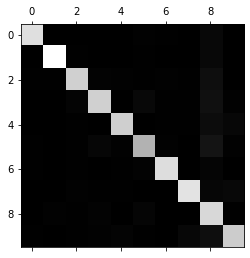

In [60]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [61]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

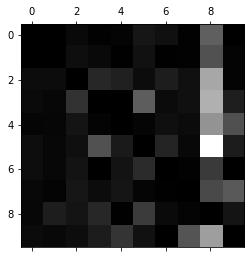

In [62]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()